# Count Stats for each Line Combination

In [1]:
import numpy as np 
import pandas as pd
import json
import pprint
import unidecode
import matplotlib.pyplot as plt

### Load, Clean, and Filter Datasets

In [2]:
# load dataset for all stats data
with open('input/2019statsAndShotLoc.json', 'rb') as f:
    stats = json.load(f)

# load txt file containing line combinations
with open('input/lineCombinations.json', 'r') as f:
    line_combinations = json.load(f)

In [3]:
# the datasets stats and line_combinations came from different sources
## there is discrepancies in the capitalizations of names ex. Nathan MacKinnon vs Nathan Mackinnon
### these discrepancies cause errors in stat counting
stats = {k.lower(): v for k, v in stats.items()}
stats = {unidecode.unidecode(k): v for k, v in stats.items()}
stats = {k.replace('.', ''): v for k, v in stats.items()}

for line in line_combinations:
    line_combinations[line] = {k.lower(): v for k, v in line_combinations[line].items()}
    line_combinations[line] = {unidecode.unidecode(k): v for k, v in line_combinations[line].items()}
    line_combinations[line] = {k.replace('.', ''): v for k, v in line_combinations[line].items()}

In [4]:
# I only care about forward line combinations, filter out all other lines
line_combinations_forwards = {}

for line in line_combinations:
    if line[-2] == 'F':
        line_combinations_forwards[line] = line_combinations[line]

### Merge Datasets into one Structure

In [5]:
# Initialize line_stats dict
line_stats = {}

for line in line_combinations_forwards:
    line_stats[line] = {}
    line_stats[line]['goals'] = 0
    line_stats[line]['assists'] = 0
    zone = ''
    for i in range(0,7):
        zone = 'count_zone' + str(i)      # column for count of shots in each zone
        line_stats[line][zone] = 0
        zone = 'percent_zone' + str(i)
        line_stats[line][zone] = 0        # column for percent of shots in each zone
    line_stats[line]['count_var'] = 0
    line_stats[line]['percent_var'] = 0
    line_stats[line]['total_shots'] = 0

In [6]:
# loop through all players in stats
# if player is in one of the lines: append their goals/assists to line_totals
for player in stats:
    for line in line_combinations_forwards:
        if player in line_combinations_forwards[line]:
            # print(line + ' ' + player + ' G' + str(stats[player]['goals']) + ' A' + str(stats[player]['assists']))
            line_stats[line]['goals'] = line_stats[line]['goals'] + stats[player]['goals']
            line_stats[line]['assists'] = line_stats[line]['assists'] + stats[player]['assists']
            
            # count shots originating from each zone
            for i in range(0,7):
                count_zone = 'count_zone' + str(i)
                zone = 'zone' + str(i)
                line_stats[line][count_zone] = line_stats[line][count_zone] + stats[player][zone]

In [7]:
# loop through all lines in line_stats
# calculate proportions of shots in all zones
for line in line_stats:
    for i in range(0,7):
        count_zone = 'count_zone' + str(i)
        line_stats[line]['total_shots'] = line_stats[line]['total_shots'] + line_stats[line][count_zone]
    
    for i in range(0,7):
        count_zone = 'count_zone' + str(i)
        percent_zone = 'percent_zone' + str(i)
        line_stats[line][percent_zone] = line_stats[line][count_zone] / line_stats[line]['total_shots']

### Calculate Variance of Shot Location for each Line Combination

In [8]:
df = pd.DataFrame(line_stats)
df_var = df.transpose()[['goals', 'assists']]

In [9]:
# using counts, calculate variance
df_counts = df.transpose()[['count_zone0', 
                            'count_zone1',
                            'count_zone2', 
                            'count_zone3', 
                            'count_zone4', 
                            'count_zone5', 
                            'count_zone6']].transpose()
df_var['count_var'] = df_counts.var()

# using percents, calculate variance
df_percents = df.transpose()[['percent_zone0', 
                            'percent_zone1',
                            'percent_zone2', 
                            'percent_zone3', 
                            'percent_zone4', 
                            'percent_zone5', 
                            'percent_zone6']].transpose()
df_var['percent_var'] = df_percents.var()

In [10]:
# calculate goals per shot to eliminate advantage of additional TOI
df_var['total_shots'] = df.transpose()[['total_shots']]
df_var['percent_zone0'] = df.transpose()[['percent_zone0']]
df_var['goals_per_shot'] = df_var['goals'] / df_var['total_shots']

In [11]:
df_var

,goals,assists,count_var,percent_var,total_shots,percent_zone0,goals_per_shot
Ducks_F1,52.0,46.0,2867.238095,0.017567,404.0,0.418317,0.128713
Ducks_F2,18.0,38.0,451.142857,0.011056,202.0,0.346535,0.089109
Ducks_F3,9.0,18.0,439.952381,0.026033,130.0,0.484615,0.069231
Ducks_F4,23.0,23.0,664.000000,0.018589,189.0,0.412698,0.121693
Coyotes_F1,36.0,37.0,945.285714,0.015369,248.0,0.387097,0.145161
...,...,...,...,...,...,...,...
Capitals_F4,20.0,29.0,982.809524,0.021065,216.0,0.449074,0.092593
Jets_F1,60.0,89.0,1887.238095,0.010597,422.0,0.315166,0.142180
Jets_F2,62.0,66.0,2742.904762,0.013133,457.0,0.376368,0.135667
Jets_F3,16.0,20.0,561.809524,0.012042,216.0,0.356481,0.074074


### Analyze Relationships

##### Variance vs Goals

Text(0, 0.5, 'Goals Scored')

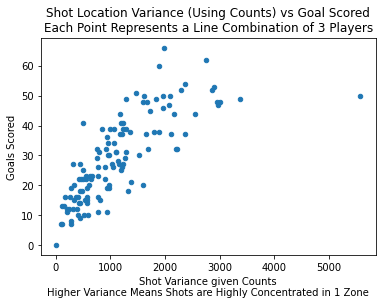

In [12]:
ax = df_var.plot.scatter(x='count_var', y='goals')
plt.title('Shot Location Variance (Using Counts) vs Goal Scored\n' + 
         'Each Point Represents a Line Combination of 3 Players')
plt.xlabel('Shot Variance given Counts\n' + 
          'Higher Variance Means Shots are Highly Concentrated in 1 Zone')
plt.ylabel('Goals Scored')

Text(0, 0.5, 'Goals Scored')

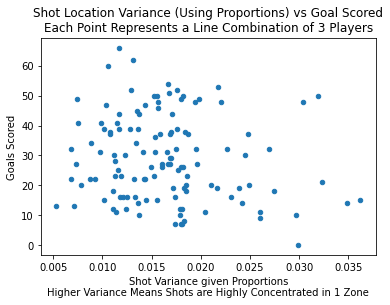

In [13]:
ax = df_var.plot.scatter(x='percent_var', y='goals')
plt.title('Shot Location Variance (Using Proportions) vs Goal Scored\n' + 
         'Each Point Represents a Line Combination of 3 Players')
plt.xlabel('Shot Variance given Proportions\n' + 
          'Higher Variance Means Shots are Highly Concentrated in 1 Zone')
plt.ylabel('Goals Scored')

Text(0, 0.5, 'Goals/Shots Taken')

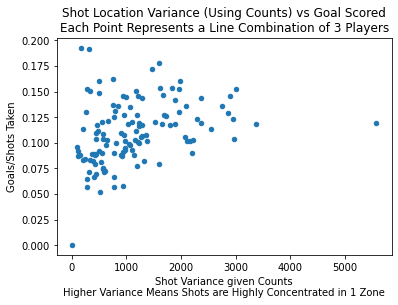

In [14]:
ax = df_var.plot.scatter(x='count_var', y='goals_per_shot')
plt.title('Shot Location Variance (Using Counts) vs Goal Scored\n' + 
         'Each Point Represents a Line Combination of 3 Players')
plt.xlabel('Shot Variance given Counts\n' + 
          'Higher Variance Means Shots are Highly Concentrated in 1 Zone')
plt.ylabel('Goals/Shots Taken')

Text(0, 0.5, 'Goals per Shot Taken')

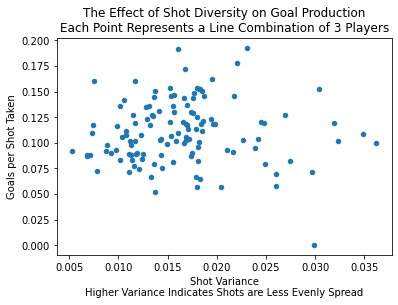

In [22]:
ax = df_var.plot.scatter(x='percent_var', y='goals_per_shot')
plt.title('The Effect of Shot Diversity on Goal Production\n' + 
         'Each Point Represents a Line Combination of 3 Players')
plt.xlabel('Shot Variance\n' + 
          'Higher Variance Indicates Shots are Less Evenly Spread')
plt.ylabel('Goals per Shot Taken')

##### Variance vs Shots

Text(0.5, 0, 'Shots Taken')

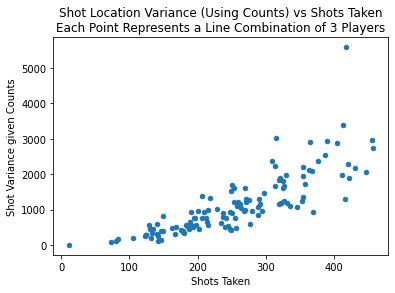

In [16]:
ax = df_var.plot.scatter(x='total_shots', y='count_var')
plt.title('Shot Location Variance (Using Counts) vs Shots Taken\n' + 
         'Each Point Represents a Line Combination of 3 Players')
plt.ylabel('Shot Variance given Counts')
plt.xlabel('Shots Taken')

Text(0.5, 0, 'Shots Taken')

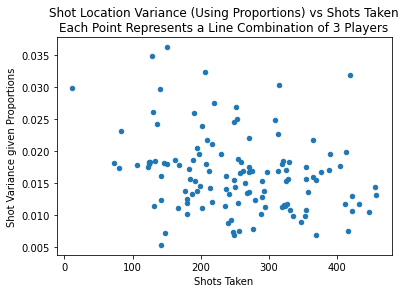

In [17]:
ax = df_var.plot.scatter(x='total_shots', y='percent_var')
plt.title('Shot Location Variance (Using Proportions) vs Shots Taken\n' + 
         'Each Point Represents a Line Combination of 3 Players')
plt.ylabel('Shot Variance given Proportions')
plt.xlabel('Shots Taken')

##### Proportion of Shots taken from zone 0 vs Goals per Shots

Text(0.5, 0, 'Proportion of Total Shots taken from Zone 0')

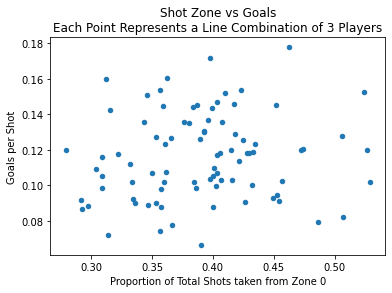

In [18]:
ax = df_var[df_var['total_shots'] >= 200].plot.scatter(x='percent_zone0', y='goals_per_shot')
plt.title('Shot Zone vs Goals\n' + 
         'Each Point Represents a Line Combination of 3 Players')
plt.ylabel('Goals per Shot')
plt.xlabel('Proportion of Total Shots taken from Zone 0')

##### Proportion of Shots taken from zone 0 vs Goals per Shots **for individual players

In [27]:
# create a df for individual players
df_stats = pd.DataFrame(stats).transpose()
df_stats

,goals,assists,zone0,zone1,zone2,zone3,zone4,zone5,zone6
sami vatanen,4,7,5,13,22,4,7,5,3
eric comrie,0,0,0,0,0,0,0,0,0
jesper bratt,15,11,36,3,5,13,9,9,11
travis zajac,7,14,26,5,3,4,2,13,8
pk subban,5,7,5,8,59,7,15,6,11
...,...,...,...,...,...,...,...,...,...
tomas nosek,7,7,51,1,1,16,5,9,7
alex tuch,6,5,29,4,8,18,2,18,10
nicolas roy,4,5,19,3,2,4,0,7,5
cody glass,4,2,15,1,0,6,3,13,9


In [38]:
# calculate proportions of shots from each zone
df_stats['total_shots'] = 0
for i in range(0,7):
    zone = 'zone' + str(i)
    df_stats['total_shots'] = df_stats['total_shots'] + df_stats[zone]

for i in range(0,7):
    pzone = 'percent_zone' + str(i)
    zone = 'zone' + str(i)
    df_stats[pzone] =  df_stats[zone] / df_stats['total_shots']

df_stats['goals_per_shots'] = df_stats['goals'] / df_stats['total_shots']
df_stats

,goals,assists,zone0,zone1,zone2,zone3,zone4,zone5,zone6,total_shots,percent_zone0,percent_zone1,percent_zone2,percent_zone3,percent_zone4,percent_zone5,percent_zone6,goals_per_shots
sami vatanen,4,7,5,13,22,4,7,5,3,59,0.084746,0.220339,0.372881,0.067797,0.118644,0.084746,0.050847,0.067797
eric comrie,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jesper bratt,15,11,36,3,5,13,9,9,11,86,0.418605,0.034884,0.058140,0.151163,0.104651,0.104651,0.127907,0.174419
travis zajac,7,14,26,5,3,4,2,13,8,61,0.426230,0.081967,0.049180,0.065574,0.032787,0.213115,0.131148,0.114754
pk subban,5,7,5,8,59,7,15,6,11,111,0.045045,0.072072,0.531532,0.063063,0.135135,0.054054,0.099099,0.045045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tomas nosek,7,7,51,1,1,16,5,9,7,90,0.566667,0.011111,0.011111,0.177778,0.055556,0.100000,0.077778,0.077778
alex tuch,6,5,29,4,8,18,2,18,10,89,0.325843,0.044944,0.089888,0.202247,0.022472,0.202247,0.112360,0.067416
nicolas roy,4,5,19,3,2,4,0,7,5,40,0.475000,0.075000,0.050000,0.100000,0.000000,0.175000,0.125000,0.100000
cody glass,4,2,15,1,0,6,3,13,9,47,0.319149,0.021277,0.000000,0.127660,0.063830,0.276596,0.191489,0.085106


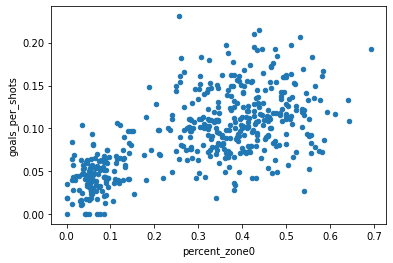

In [47]:
# graph relationship
ax = df_stats[df_stats['total_shots'] >= 50].plot.scatter(x='percent_zone0', y='goals_per_shots')
